<H1>HC in Cross-Domain Authorship Attribution Challenge</H1>
Use this notebook to replicate the results reporter in the paper  </br>
<ul>
    [1] <a href = https://arxiv.org/abs/1911.01208>
    Kipnis, A., ``Higher Criticism for Discriminating Word-Frequency Tables and Testing Authorship'', 2019
    </a>
</ul>

- Use HC-based test to attribute authorship in the PAN2018 cross-domain authorship attribution challenge https://pan.webis.de/clef18/pan18-web/author-identification.html#cross-domain
- Only the English part (problems 1-4) of this challenge is considered. 
- We use a lemmatized version of the data obtained using the Stanford CoreNLP (https://stanfordnlp.github.io/CoreNLP/)



In [1]:
import pandas as pd
import numpy as np
import os
import re
import codecs
from tqdm import tqdm

#import auxiliary functions for python
import sys
sys.path.append('../')
from AuthAttLib import *

<H2>Load Data</H2>
<a href = https://www.uni-weimar.de/medien/webis/corpora/corpus-pan-labs-09-today/pan-18/pan18-data/pan18-cross-domain-authorship-attribution-test-dataset2-2018-04-20-password-protected.zip>Link</a> to dataset. 
Below is a lemmatized version of this dataset arranged in a csv format 


In [81]:
#load dataset 
raw_data = pd.read_csv("../Data/PAN2018_lemmatized.csv")
raw_data = raw_data.rename(columns={'dataset' : 'prob'})

In [34]:
# optional: remove proper names, cardinal digits, and punctuation
from text_processing import remove_parts_of_speach
punct = [':',';','"','(',')','-',',','.','`','\`','!']

def text_proc_loc(text) : 
    return remove_parts_of_speach(text, 
                        to_remove=['NNP', 'NNPS', 'CD'] #remove proper names and cardinal digits
                    )
def lemmatize_vocab(list_of_words) :
    return text_proc_loc(" ".join(list_of_words)).split()


Ignore proper names, numbers, and some pronouns: 

In [82]:
data = raw_data.filter(['dataset', 'author', 'doc_id', 'prob'])
data.loc[:,'split'] = 'train'
data.loc[data.doc_id.str.find('test')>-1,'split'] = 'test'
data.loc[:,'text'] = raw_data['text']

In [37]:
#Optional: remove POS: proper names and cardinal digits (can take a while)
data.loc[:,'text'] = raw_data.text.apply(text_proc_loc)

<H2>Multi-author model</H2>

- For each problem in the challenge, train a model and evaluate it over a test set. <br>
- The following implementation opt not to use the UNNKOWN option, hence the recall is always 100%

In [85]:
lo_problem = pd.unique(data['prob'])

lo_F1 = []
lo_acc = []

for prob in tqdm(lo_problem) :
    data_prob = data[data['prob'] == prob]
    
    data_train = data_prob[data_prob['split'] == 'train']
    #compute model for each problem:
    model = AuthorshipAttributionMulti(
        data_train,        #dataset arrange in a data frame
        vocab_size=3000,  #uses 3000 most frequent ngram
        ngram_range=(1,1), #mono-, bi-, and tri- grams
        )
    
    #attribute test documents:
    print("Evaluate on test set:")
    data_test = data_prob[data_prob['split'] == 'test']
    lo_test_docs = pd.unique(data_test.doc_id)
    df = pd.DataFrame() #save results in this dataframe

    for doc in tqdm(lo_test_docs) :
        sm = data_test[data_test.doc_id == doc]
        
        pred,_ = model.predict(sm.text.values[0], unk_thresh = 1e6, method = 'HC') 
                # can use 'unk_thresh' to get '<UNK>' instead of the name 
                # of the corpus with smallest HC in the case when the smallest
                # HC is above 'unk_thresh'. 

        auth = sm.author.values[0]
        df = df.append({'doc_id' : doc,
                   'author' : auth,
                   'predicted' : pred,
                  }, ignore_index = True)


    # evaluate accuracy and F1 score
    df_r = df[df.predicted != '<UNK>']
    recall = len(df_r) / len(df)
    acc = np.mean((df_r.predicted == df_r.author).values)
    
    print("problem = {}".format(prob))
    print("recall = {}".format(recall))
    print("accuracy = {}".format(acc))
    print("F1 = {}".format(2*recall*acc / (recall + acc)))
    lo_F1 += [2*recall*acc / (recall + acc)]
    lo_acc += [acc]

#prob1: |W| = 1500, ng = (1,3) --> F1 = 0.661, acc = 0.493
#prob2: |W| = 1500, ng = (1,3) --> F1 = 0.678, acc = 0.513
#prob3: |W| = 1500, ng = (1,3) --> F1 = 0.7878, acc = 0.65
#prob4: |W| = 1500, ng = (1,3) --> F1 = 0.814, acc = 0.6875

print("\n mean F1 = ", np.mean(lo_F1))

  0%|          | 0/4 [00:00<?, ?it/s]

	 Creating author-model for candidate00001 using 3000 features...
		found 7 documents and 6368 relevant tokens.
	 Creating author-model for candidate00002 using 3000 features...
		found 7 documents and 6258 relevant tokens.
	 Creating author-model for candidate00003 using 3000 features...
		found 7 documents and 6038 relevant tokens.
	 Creating author-model for candidate00004 using 3000 features...
		found 7 documents and 6214 relevant tokens.
	 Creating author-model for candidate00005 using 3000 features...
		found 7 documents and 5608 relevant tokens.
	 Creating author-model for candidate00006 using 3000 features...
		found 7 documents and 6167 relevant tokens.
	 Creating author-model for candidate00007 using 3000 features...
		found 7 documents and 6134 relevant tokens.
	 Creating author-model for candidate00008 using 3000 features...
		found 7 documents and 6169 relevant tokens.
	 Creating author-model for candidate00009 using 3000 features...
		found 7 documents and 6030 relevant 


  0%|          | 0/79 [00:00<?, ?it/s]

		found 7 documents and 6163 relevant tokens.
	 Creating author-model for candidate00016 using 3000 features...
		found 7 documents and 5445 relevant tokens.
	 Creating author-model for candidate00017 using 3000 features...
		found 7 documents and 5906 relevant tokens.
	 Creating author-model for candidate00018 using 3000 features...
		found 7 documents and 6001 relevant tokens.
	 Creating author-model for candidate00019 using 3000 features...
		found 7 documents and 5810 relevant tokens.
	 Creating author-model for candidate00020 using 3000 features...
		found 7 documents and 5907 relevant tokens.
Evaluate on test set:



 25%|██▌       | 1/4 [00:04<00:12,  4.23s/it]s]

problem = PAN-problem00001
recall = 1.0
accuracy = 0.4936708860759494
F1 = 0.6610169491525424
	 Creating author-model for candidate00001 using 3000 features...
		found 7 documents and 6321 relevant tokens.
	 Creating author-model for candidate00002 using 3000 features...
		found 7 documents and 5969 relevant tokens.
	 Creating author-model for candidate00003 using 3000 features...
		found 7 documents and 6041 relevant tokens.
	 Creating author-model for candidate00004 using 3000 features...
		found 7 documents and 6289 relevant tokens.
	 Creating author-model for candidate00005 using 3000 features...
		found 7 documents and 5468 relevant tokens.
	 Creating author-model for candidate00006 using 3000 features...
		found 7 documents and 5993 relevant tokens.
	 Creating author-model for candidate00007 using 3000 features...
		found 7 documents and 6201 relevant tokens.
	 Creating author-model for candidate00008 using 3000 features...



  0%|          | 0/74 [00:00<?, ?it/s]

		found 7 documents and 6018 relevant tokens.
	 Creating author-model for candidate00009 using 3000 features...
		found 7 documents and 5997 relevant tokens.
	 Creating author-model for candidate00010 using 3000 features...
		found 7 documents and 5849 relevant tokens.
	 Creating author-model for candidate00011 using 3000 features...
		found 7 documents and 5662 relevant tokens.
	 Creating author-model for candidate00012 using 3000 features...
		found 7 documents and 6110 relevant tokens.
	 Creating author-model for candidate00013 using 3000 features...
		found 7 documents and 5947 relevant tokens.
	 Creating author-model for candidate00014 using 3000 features...
		found 7 documents and 6148 relevant tokens.
	 Creating author-model for candidate00015 using 3000 features...
		found 7 documents and 6427 relevant tokens.
Evaluate on test set:



 50%|█████     | 2/4 [00:06<00:07,  3.79s/it]s]

problem = PAN-problem00002
recall = 1.0
accuracy = 0.5540540540540541
F1 = 0.7130434782608697
	 Creating author-model for candidate00001 using 3000 features...
		found 7 documents and 6075 relevant tokens.
	 Creating author-model for candidate00002 using 3000 features...
		found 7 documents and 6357 relevant tokens.
	 Creating author-model for candidate00003 using 3000 features...
		found 7 documents and 6044 relevant tokens.
	 Creating author-model for candidate00004 using 3000 features...
		found 7 documents and 5870 relevant tokens.
	 Creating author-model for candidate00005 using 3000 features...
		found 7 documents and 6330 relevant tokens.
	 Creating author-model for candidate00006 using 3000 features...
		found 7 documents and 5995 relevant tokens.
	 Creating author-model for candidate00007 using 3000 features...
		found 7 documents and 5684 relevant tokens.
	 Creating author-model for candidate00008 using 3000 features...
		found 7 documents and 6313 relevant tokens.
	 Creating


 12%|█▎        | 5/40 [00:00<00:00, 43.01it/s]

		found 7 documents and 6489 relevant tokens.
Evaluate on test set:



  0%|          | 0/16 [00:00<?, ?it/s]

problem = PAN-problem00003
recall = 1.0
accuracy = 0.7
F1 = 0.8235294117647058
	 Creating author-model for candidate00001 using 3000 features...
		found 7 documents and 6343 relevant tokens.
	 Creating author-model for candidate00002 using 3000 features...
		found 7 documents and 6211 relevant tokens.
	 Creating author-model for candidate00003 using 3000 features...
		found 7 documents and 6465 relevant tokens.
	 Creating author-model for candidate00004 using 3000 features...
		found 7 documents and 6300 relevant tokens.
	 Creating author-model for candidate00005 using 3000 features...
		found 7 documents and 5591 relevant tokens.
Evaluate on test set:



100%|██████████| 4/4 [00:08<00:00,  2.24s/it]s]

problem = PAN-problem00004
recall = 1.0
accuracy = 0.6875
F1 = 0.8148148148148148

 mean F1 =  0.7531011634982332


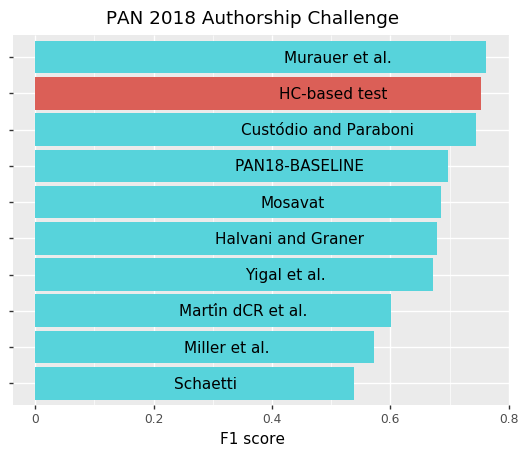

<ggplot: (329661097)>


/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: PAN2018_F1.png
  warn('Filename: {}'.format(filename))


In [86]:
PAN2018_English_results = {
'Custódio and Paraboni' : 0.744,
'Murauer et al.' : 0.762,
'Halvani and Graner' :  0.679,
'Mosavat' : 0.685,
'Yigal et al.' : 0.672,
'Martín dCR et al.' : 0.601,
'PAN18-BASELINE' : 0.697,
'Miller et al.' : 0.573,
'Schaetti' :  0.538}

#from 

from plotnine import *

PAN2018_English_results['HC-based test'] = np.mean(lo_F1)

df = pd.DataFrame.from_dict(PAN2018_English_results, orient='index')
df = df.rename(columns = {0 : 'F1'}).reset_index()
dfs = df.sort_values('F1').reset_index()
df['cat'] = pd.Categorical(df.F1, categories=dfs['F1'].values, ordered=True)


df['type'] = 'other'
df.loc[df['index'] == 'HC-based test','type']='HC'

p = (ggplot(aes(x = 'cat', y = 'F1', fill = 'type', label = 'index'), data = df)
     + geom_bar(position='dodge', stat="identity", show_legend=False)
     + geom_text(nudge_y = -0.25) + coord_flip() + ggtitle('PAN 2018 Authorship Challenge')
     + xlab('') + theme(axis_text_y=element_blank())
     + ylab('F1 score')
    )
print(p)

path_to_plots = "/Users/kipnisal/Dropbox/Apps//Overleaf/Higher Criticism and Authorship Attribution (presentation)/Figs/"
path_to_plots =""
p.save(path_to_plots + 'PAN2018_F1.png')

<h2>Multi-author with head-to-head comparisons</h2>

Compare each pair of corpora. Use only distinguishing features of two corpora in testing. Attribute tested docuement to whichever corpus has most number of wins in all pairwise comparisons.

In [11]:
lo_problem = pd.unique(data['dataset'])

lo_F1 = []
lo_acc = []

for prob in tqdm(lo_problem[2:4]) :
    data_prob = data[data['dataset'] == prob]
    data_train = data_prob[data_prob['split'] == 'train']
    
    #compute model for each problem:
    model = AuthorshipAttributionMultiBinary(data_train, 
                                       vocab_size = 1500,  #uses most frequent ngram
                                       stbl = True,  #type of HC statistic
                                      ngram_range = (1,3), #mono-, bi-, and tri- grams
                                         reduce_features=True,
                                         randomize=True
                                                )
    
    #attribute test documents:
    data_test = data_prob[data_prob['split'] == 'test']
    lo_test_docs = pd.unique(data_test.doc_id)
    df = pd.DataFrame() #save results in this dataframe

    for doc in tqdm(lo_test_docs) :
        sm = data_test[data_test.doc_id == doc]

        pred = model.predict(sm.text.values[0], method = 'chisq_pval', LOO = False) 
                # can use 'unk_thresh' to get '<UNK>' instead of the name 
                # of the corpus with smallest HC in the case when the smallest
                # HC is above 'unk_thresh'. 

        auth = sm.author.values[0]
        df = df.append({'doc_id' : doc,
                   'author' : auth,
                   'predicted' : pred,
                  }, ignore_index = True)


    # evaluate accuracy and F1 score
    df_r = df[df.predicted != '<UNK>']
    recall = len(df_r) / len(df)
    acc = np.mean((df_r.predicted == df_r.author).values)
    
    print("problem = {}".format(prob))
    print("recall = {}".format(recall))
    print("accuracy = {}".format(acc))
    print("F1 = {}".format(2*recall*acc / (recall + acc)))
    lo_F1 += [2*recall*acc / (recall + acc)]
    lo_acc += [acc]

#prob4: F1 = 0.72, acc = 0.5625, |W| = 100, ng = (1,3)


  0%|          | 0/2 [00:00<?, ?it/s]

Found 45 author-pairs
MultiBinaryAuthorModel: Creating model for candidate00001 vs candidate00002...
	 Creating author-model for candidate00001 using 1500 features...
		found 7 documents and 8126 relevant tokens.
	 Creating author-model for candidate00002 using 1500 features...
		found 7 documents and 9304 relevant tokens.
Changing vocabulary for candidate00001. Found 1335 relevant tokens.
Changing vocabulary for candidate00002. Found 1496 relevant tokens.
Reduced to 51 features...
MultiBinaryAuthorModel: Creating model for candidate00001 vs candidate00003...
	 Creating author-model for candidate00001 using 1500 features...
		found 7 documents and 8145 relevant tokens.
	 Creating author-model for candidate00003 using 1500 features...
		found 7 documents and 7406 relevant tokens.
Changing vocabulary for candidate00001. Found 1393 relevant tokens.
Changing vocabulary for candidate00003. Found 1446 relevant tokens.
Reduced to 41 features...
MultiBinaryAuthorModel: Creating model for candi

Changing vocabulary for candidate00004. Found 3163 relevant tokens.
Reduced to 53 features...
MultiBinaryAuthorModel: Creating model for candidate00003 vs candidate00005...
	 Creating author-model for candidate00003 using 1500 features...
		found 7 documents and 7274 relevant tokens.
	 Creating author-model for candidate00005 using 1500 features...
		found 7 documents and 9705 relevant tokens.
Changing vocabulary for candidate00003. Found 3711 relevant tokens.
Changing vocabulary for candidate00005. Found 4560 relevant tokens.
Reduced to 532 features...
MultiBinaryAuthorModel: Creating model for candidate00003 vs candidate00006...
	 Creating author-model for candidate00003 using 1500 features...
		found 7 documents and 7517 relevant tokens.
	 Creating author-model for candidate00006 using 1500 features...
		found 7 documents and 8901 relevant tokens.
Changing vocabulary for candidate00003. Found 3627 relevant tokens.
Changing vocabulary for candidate00006. Found 4180 relevant tokens.
R

	 Creating author-model for candidate00006 using 1500 features...
		found 7 documents and 8697 relevant tokens.
	 Creating author-model for candidate00008 using 1500 features...
		found 7 documents and 9657 relevant tokens.
Changing vocabulary for candidate00006. Found 2257 relevant tokens.
Changing vocabulary for candidate00008. Found 2182 relevant tokens.
Reduced to 61 features...
MultiBinaryAuthorModel: Creating model for candidate00006 vs candidate00009...
	 Creating author-model for candidate00006 using 1500 features...
		found 7 documents and 8913 relevant tokens.
	 Creating author-model for candidate00009 using 1500 features...
		found 7 documents and 8347 relevant tokens.
Changing vocabulary for candidate00006. Found 1358 relevant tokens.
Changing vocabulary for candidate00009. Found 1084 relevant tokens.
Reduced to 36 features...
MultiBinaryAuthorModel: Creating model for candidate00006 vs candidate00010...
	 Creating author-model for candidate00006 using 1500 features...
		fo


  0%|          | 0/40 [00:00<?, ?it/s]

		found 7 documents and 9502 relevant tokens.
Changing vocabulary for candidate00009. Found 1543 relevant tokens.
Changing vocabulary for candidate00010. Found 2145 relevant tokens.
Reduced to 50 features...


../HC_aux.py:50: RuntimeWarning: divide by zero encountered in true_divide
  z = (uu - ps) / np.sqrt(ps * (1 - ps)) * np.sqrt(n)

 50%|█████     | 1/2 [00:22<00:22, 22.78s/it]s]

problem = PAN-problem00003
recall = 1.0
accuracy = 0.7
F1 = 0.8235294117647058
Found 10 author-pairs
MultiBinaryAuthorModel: Creating model for candidate00001 vs candidate00002...
	 Creating author-model for candidate00001 using 1500 features...
		found 7 documents and 8389 relevant tokens.
	 Creating author-model for candidate00002 using 1500 features...
		found 7 documents and 8290 relevant tokens.
Changing vocabulary for candidate00001. Found 2720 relevant tokens.
Changing vocabulary for candidate00002. Found 2901 relevant tokens.
Reduced to 417 features...
MultiBinaryAuthorModel: Creating model for candidate00001 vs candidate00003...
	 Creating author-model for candidate00001 using 1500 features...
		found 7 documents and 8302 relevant tokens.
	 Creating author-model for candidate00003 using 1500 features...
		found 7 documents and 9295 relevant tokens.
Changing vocabulary for candidate00001. Found 1592 relevant tokens.
Changing vocabulary for candidate00003. Found 2073 relevant to


  0%|          | 0/16 [00:00<?, ?it/s]

Changing vocabulary for candidate00004. Found 4442 relevant tokens.
Changing vocabulary for candidate00005. Found 4485 relevant tokens.
Reduced to 548 features...



100%|██████████| 2/2 [00:27<00:00, 17.24s/it]s]

problem = PAN-problem00004
recall = 1.0
accuracy = 0.625
F1 = 0.7692307692307693


<H1>Other Classifyers</H1>

In [71]:
import pandas as pd
import numpy as np
import os
import pickle
import nltk
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
import sys

from AuthAttLib import AuthorshipAttributionMulti, to_docTermCounts
from FreqTable import FreqTable

def evaluate_classifyer(Cls, X_train, y_train, X_test, y_test, **kwargs) :
    clf = Cls(**kwargs)
    clf.fit(X_train,y_train)
    return clf.score(X_test, y_test)

def evaluate_Clf(Cls, X_train, y_train,
                 X_test, y_test,
                 vocab, **kwargs) :
    print('using {}'.format(Cls))
    acc = []
    clf = Cls(**kwargs)

    clf.fit(X_train,y_train)
    acc = clf.score(X_test, y_test)
    return acc

    clf.fit(X_train,y_train)
    return clf.score(X_test, y_test)

def get_counts_labels(df, vocab) :
#prepare data:
    X = []
    y = []
    for r in df.iterrows() :
        dt = to_docTermCounts([r[1].text], 
                            vocab=vocab
                             )
        X += [FreqTable(dt[0], dt[1])._counts]
        y += [r[1].author]
    
    return X, y

classifiers = {#'logistic_regression' : LogisticRegression,
                'multinomial_NB' : MultinomialNB,
                 'SVM' : LinearSVC,
                 'KNN' : KNeighborsClassifier,
                  }

lo_args = {'logistic_regression' : {'solver': 'lbfgs',
                                   'max_iter' : 150},
            'multinomial_NB' : {},
                 'SVM' : {'dual' : False},
                 'KNN' : {'metric' : 'cosine',
                          'n_neighbors' : 5},
            }

df = pd.DataFrame()

lo_problem = pd.unique(data['prob'])

for prob in tqdm(lo_problem[:4]) :
    data_prob = data[data['prob'] == prob]
    vocab = model._vocab
    acc = {}

    X_train, y_train = get_counts_labels(data_prob[data_prob.split=='train'], vocab)
    X_test, y_test = get_counts_labels(data_prob[data_prob.split=='test'], vocab)

    for cls in classifiers : 
        Cls = classifiers[cls]
        args = lo_args[cls]
        acc[cls] = evaluate_Clf(Cls, X_train,y_train, X_test, y_test, vocab, **args)

    df = df.append(pd.DataFrame(acc, index = [0]), ignore_index = True)
    
print(df.apply(lambda x : 2*x/(1+x)).mean())

  0%|          | 0/4 [00:00<?, ?it/s]

using <class 'sklearn.naive_bayes.MultinomialNB'>
using <class 'sklearn.svm.classes.LinearSVC'>


 25%|██▌       | 1/4 [00:01<00:03,  1.21s/it]

using <class 'sklearn.neighbors.classification.KNeighborsClassifier'>


 50%|█████     | 2/4 [00:02<00:02,  1.10s/it]

using <class 'sklearn.naive_bayes.MultinomialNB'>
using <class 'sklearn.svm.classes.LinearSVC'>
using <class 'sklearn.neighbors.classification.KNeighborsClassifier'>


 75%|███████▌  | 3/4 [00:02<00:00,  1.07it/s]

using <class 'sklearn.naive_bayes.MultinomialNB'>
using <class 'sklearn.svm.classes.LinearSVC'>
using <class 'sklearn.neighbors.classification.KNeighborsClassifier'>


100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

using <class 'sklearn.naive_bayes.MultinomialNB'>
using <class 'sklearn.svm.classes.LinearSVC'>
using <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
multinomial_NB    0.788790
SVM               0.779025
KNN               0.722156
dtype: float64
